# Syllabification

## Importing libraries

In [177]:
import librosa
import librosa.display
import os
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from scipy.signal import lfilter
from scipy.signal import hilbert
from scipy.signal import peak_prominences

In [178]:
sr = 16000
frame_size = 0.02
frame_stride = 0.01
NFFT = 512

## Preprocessing

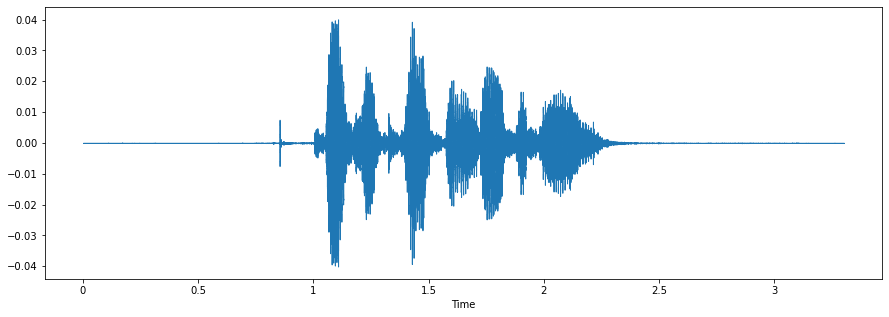

In [179]:
fname = input("Enter the name of the audio file: ")

new,srr = librosa.load(fname, sr=sr)
new = librosa.resample(new, orig_sr=srr, target_sr=sr)
t = np.linspace(0, len(new) / sr, num=len(new))
plt.figure(figsize=(15, 5))
librosa.display.waveshow(new, sr=sr)
ipd.Audio(fname)

list_files = []
mfcc_con=np.empty([0, 13])
hop_length = int(0.01*sr)
win_length=int(0.02*sr)
path = "ravdess-data/Actor_01/"
for file in os.listdir("ravdess-data/Actor_01/"):
        
        if file.endswith('.wav'):   
            file = os.path.join(path, file)
        
            new,srr = librosa.load(file)
            new = librosa.resample(new, orig_sr=srr, target_sr=sr)
            list_files.append(new)
        
            mfcc = librosa.feature.mfcc(y=new, sr=sr, hop_length=hop_length, n_mfcc=13,win_length=win_length).T
            mfcc_con = np.concatenate((mfcc_con,mfcc),axis=0)

In [180]:
frame_length, frame_step = frame_size * sr, frame_stride * sr
signal_length = len(new)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(new, z)

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]
#frames *= np.hamming(frame_size*sr)
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

Text(0.5, 1.0, 'Signal')

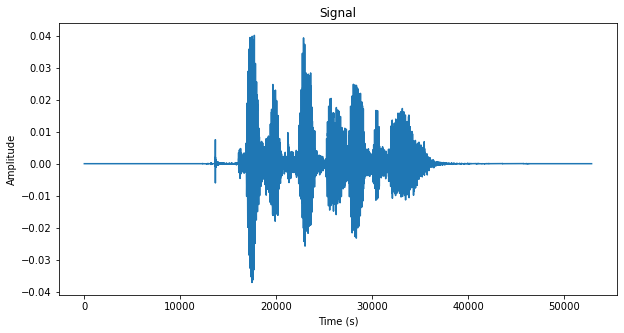

In [181]:
figure, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(new)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Signal")

#figure, ax = plt.subplots(1, 1, figsize=(10, 5))
#ax.plot(mag_frames)

## Short time Energy

In [182]:
STEs = []
for k in range(num_frames):
     #window = np.zeros(new.shape)
     window = np.hamming(320)          # rectangular window
     STE = sum((frames[k] ** 2)*(window ** 2))
     STEs.append(STE)
     
#  e = utils.ste(new, scipy.signal.get_window("hamming", 201))

Text(0.5, 0, 'FRAME')

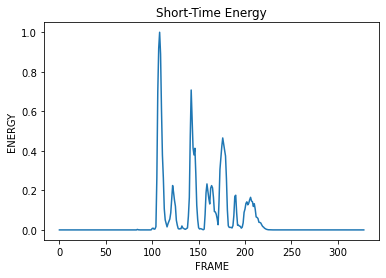

In [183]:
plt.plot(STEs/max(STEs))
plt.title('Short-Time Energy')
plt.ylabel('ENERGY')
plt.xlabel('FRAME')
 #pyplot.autoscale(tight='both');

## Most Dominant Frequency

In [184]:
MDF = []
for k in range(num_frames):
    dft = np.fft.rfft(frames[k])
    dft = abs(max(dft))
    MDF.append(dft)

Text(0.5, 0, 'FRAME')

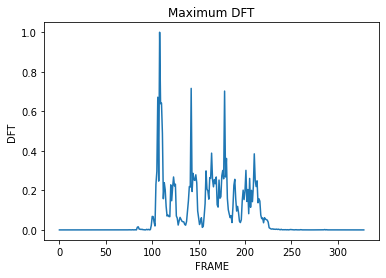

In [185]:
plt.plot(MDF/max(MDF))
plt.title('Maximum DFT')
plt.ylabel('DFT')
plt.xlabel('FRAME')

In [186]:
coeff = librosa.lpc(new, order=10)
coeffarr = np.hstack([[0], -1 * coeff[1:]])
new_hat = lfilter(coeffarr, [1], new)
res = new - new_hat

lp_hil = hilbert(res)
h_env = np.sqrt((np.abs(lp_hil))**2 + (np.abs(res))**2)

hmin = min(h_env)
hmax = max(h_env)
for i in range(len(h_env)):
    h_env[i] = (h_env[i]-hmin)/(hmax-hmin)
k = 400
kernel = np.ones(k)/(k)
smooth_henv = np.convolve(h_env,kernel, mode='same')

In [187]:
Lg = 100
gd = np.zeros(Lg)
sigma = 100/6
const = 1/(sigma*np.sqrt(2*np.pi))
for n in range(1,Lg):
    gd[n] = const*(np.exp(-(n+1-40)**2/(2*sigma**2))-np.exp(-((n-40)**2)/(2*sigma**2)))

In [192]:
k = 8
j= 0
kernel = np.ones(k)/(k)
smooth2_henv = np.convolve(h_env,kernel, mode='same')
henv_conv = np.convolve(smooth2_henv,-gd, mode='same')
sign = np.sign(henv_conv)
z = np.ones(len(sign))*0.0
for i in range(1,len(sign)):
    if(sign[i-1] == -1 and sign[i] == 1):
        z[i] = 0
        j += 1
        
        
pmin,_ = find_peaks(henv_conv, distance=200*sr/1000)
z[pmin] = 1
for i in range(len(new)):
    if(new[i] == 0):
        z[i] = 0   
    f = int(i//160)-2
    #if (STEs[f] < 0.2):
        #z[i] = 0

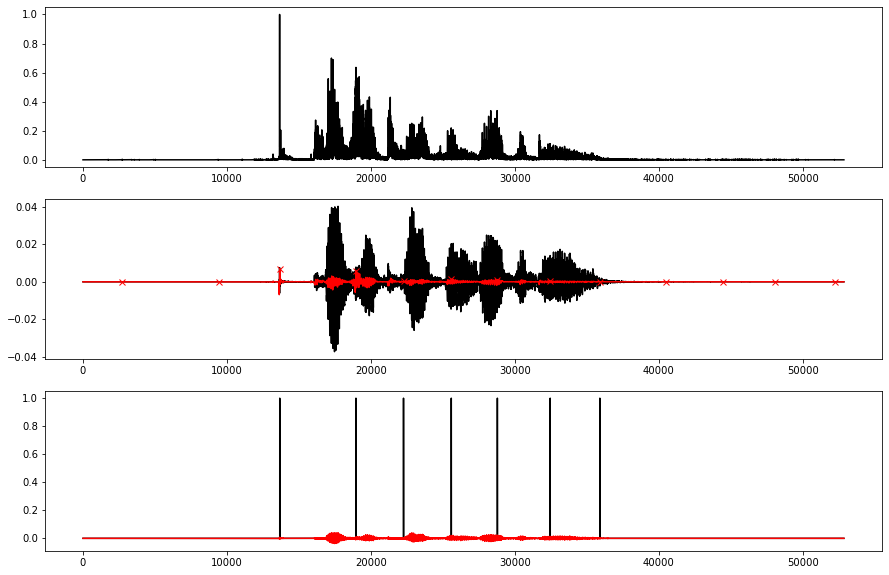

In [193]:
fig, ax = plt.subplots(3, figsize=(15, 10))
ax[0].plot(h_env, color="black")
ax[1].plot(new, color="black")
ax[1].plot(henv_conv, color="red")
ax[1].plot(pmin, henv_conv[pmin], "x", color="red")
ax[2].plot(z, color="black")
ax[2].plot(new, color="red")
plt.show()

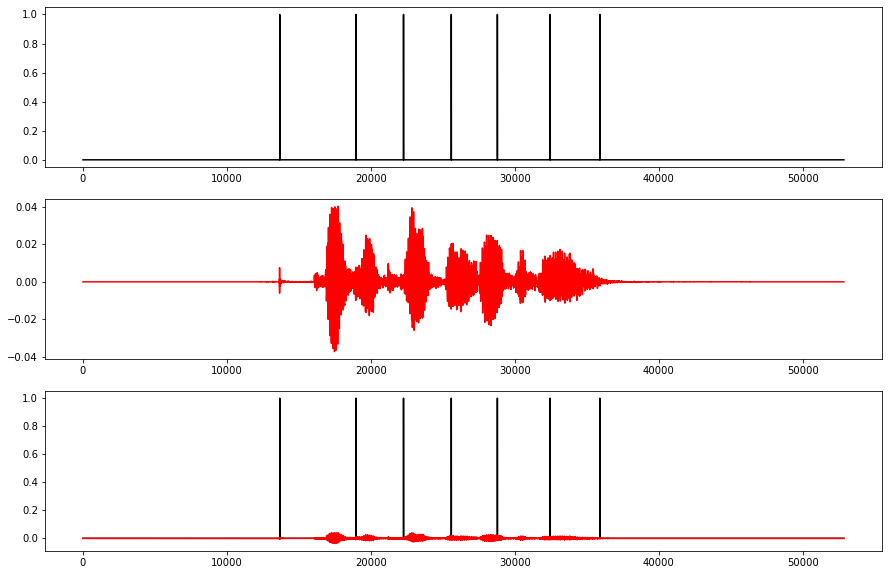

In [195]:
fig, ax = plt.subplots(3, figsize=(15, 10))
ax[0].plot(z, color="black")
ax[1].plot(new, color="red")
ax[2].plot(z, color="black")
ax[2].plot(new, color="red")